In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
import pathlib
import PIL
import time
import zipfile
import random
from tensorflow import keras as ks
from tensorflow.keras.layers import *
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from fastai.vision.all import *

In [3]:
train_df = pd.read_csv("../input/makerere-passion-fruit-disease-detection-challenge/Train (11).csv")
test_df = pd.read_csv("../input/makerere-passion-fruit-disease-detection-challenge/Test (12).csv")
sub=pd.read_csv("../input/makerere-passion-fruit-disease-detection-challenge/Sample_submission (5).csv")

In [4]:
train=[]
test=[]
diir="../input/makerere-passion-fruit-disease-detection-challenge/Train_Images/Train_Images/"
for i in os.listdir(diir):
    path=diir+i
    train.append(path)
dirr="../input/makerere-passion-fruit-disease-detection-challenge/Test_Images (1)/Test_Images/"
for i in os.listdir(dirr):
    path=dirr+i
    test.append(path)

In [5]:
clas = train_df["class"][:3001]
xmin = train_df["xmin"][:3001]
ymin = train_df["ymin"][:3001]
width = train_df["width"][:3001]
height = train_df["height"][:3001]

In [6]:
df=pd.DataFrame({'path':train, 'class':clas, 'xmin':xmin, 'ymin':ymin, 'width':width, 'height':height})

In [7]:
test_d=pd.DataFrame({'path':test})

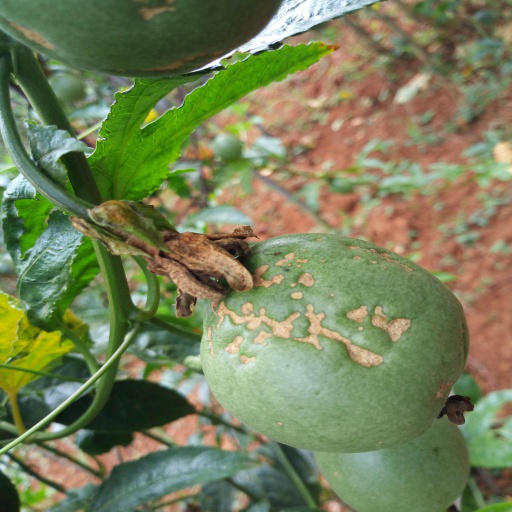

In [8]:
from PIL import Image
img = Image.open(df.loc[0,"path"])
img

In [13]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=0fccce562a6d45a4ba6fc6eaffe023f0d681f89c31a48eba9a170a41df1d43b0
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [61]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mimetypes
import argparse
import imutils
import pickle
import cv2
import os

In [62]:
# initialize the list of data (images), class labels, target bounding
# box coordinates, and image paths
print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

[INFO] loading dataset...


In [63]:
# train and test directories, load files into variables
train_dir = '../input/makerere-passion-fruit-disease-detection-challenge/Train (11).csv'
test_dir = '../input/makerere-passion-fruit-disease-detection-challenge/Test (12).csv'

train_df = pd.read_csv(train_dir)
test_df = pd.read_csv(test_dir)

# add new features xmax and ymax and classes
train_df['xmax'] = train_df['xmin']+train_df['width']
train_df['ymax'] = train_df['ymin']+train_df['height']
classes_la = {"fruit_brownspot": 1, "fruit_healthy": 2, "fruit_woodiness":3}
classes_la = {"fruit_brownspot": 1, "fruit_healthy": 2, "fruit_woodiness":3}

train_df["class"] = train_df["class"].apply(lambda x: classes_la[x])

In [64]:
df = train_df.copy()

df.drop('width', inplace=True, axis=1)
df.drop('height', inplace=True, axis=1)
df.head()

,Image_ID,class,xmin,ymin,xmax,ymax
0,ID_007FAIEI,3,87.0,87.5,315.0,398.5
1,ID_00G8K1V3,1,97.5,17.5,342.5,372.0
2,ID_00WROUT9,1,156.5,209.5,404.5,512.0
3,ID_00ZJEEK3,2,125.0,193.0,379.5,410.0
4,ID_018UIENR,1,79.5,232.5,313.0,414.5


In [65]:
df = df.to_numpy()
df = df.tolist()

In [66]:
for row in df:
         imageId, label, startX, startY, endX, endY = row
         imagePath = '../input/makerere-passion-fruit-disease-detection-challenge/Train_Images/Train_Images/'+imageId + '.jpg'

     
         image = cv2.imread(imagePath)
         (h,w) = image.shape[:2]

   #scale bounding boxes
         startX  = float(startX) / w
         startY  = float(startY) / h
         endX  = float(endX) / w
         endY  = float(endY) / h

  #load and preproess image
         image = load_img(imagePath, target_size=(224,224))
         image = img_to_array(image)

  #update
         data.append(image)
         labels.append(label)
         bboxes.append((startX, startY, endX, endY))
         imagePaths.append(imagePath)

In [ ]:
#convert data to nupy array
#scale image data to 0-1
data = np.array(data, dtype='float32')/255.0
labels = np.array(labels)
bboxes = np.array(bboxes,dtype='float32')
imagePaths = np.array(imagePaths)

#perform onehot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(labels)

In [ ]:
image = np.expand_dims(data[0],axis=1)
image

In [ ]:
del image

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths, test_size=0.2, random_state=34)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [ ]:
# load the ResNet50V2 network, ensuring the head FC layers are left off
rn50v2 = ResNet50V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freeze all ResNet50V2 layers so they will *not* be updated during the
# training process
rn50v2.trainable = False

# flatten the max-pooling output of VGG
flatten = rn50v2.output
flatten = Flatten()(flatten)

In [ ]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flattenn = vgg.output
flatten = Flatten()(flattenn)

In [ ]:
rn50v2.input

In [56]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHeadd = Dense(64, activation="relu")(bboxHead)
bboxHad = Dense(32, activation="relu")(bboxHeadd)
bboxHead = Dense(5, activation="sigmoid", name="bounding_box")(bboxHad)

# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(inputs=rn50v2.input, outputs=(bboxHead, softmaxHead))

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_6'), name='input_6', description="created by layer 'input_6'") at layer "block1_conv1". The following previous layers were accessed without issue: []

In [39]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(inputs=rn50v2.input, outputs=(bboxHead, softmaxHead))
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {"class_label": "categorical_crossentropy", "bounding_box": "mean_squared_error",
}

# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {"class_label": 1.0,"bounding_box": 1.0
}

# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=1e-4)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'") at layer "block1_conv1". The following previous layers were accessed without issue: []

In [ ]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}

# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [ ]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=32,
	epochs=20,
	verbose=1)

# serialize the model to disk
print("[INFO] saving object detector model...")
model.save('model2_rn50v2base', save_format="h5")

# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open('model2_binarizer', "wb")
f.write(pickle.dumps(lb))
f.close()

In [ ]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
P = np.arange(0, 20)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(P, H.history[l], label=l)
	ax[i].plot(P, H.history["val_" + l], label="val_" + l)
	ax[i].legend()

# display the plot
plt.tight_layout()
plt.show()

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(P, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(P, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# display the plot
plt.show()

In [ ]:
plt.plot(P, H.history["class_label_accuracy"],
	label="class_label_train_acc")

In [ ]:
test_images_dir = 'Test_Images/'
test_df.head()
testImageIds = test_df['Image_ID'].to_numpy().tolist()
testImageIds
ids = []
label = []
xmin = []
confidence = []
ymin =[]
xmax= []
ymax=[]
count = 0
for tid in testImageIds:
  imagePath = test_images_dir+tid+'.jpg'
  image = load_img(imagePath, target_size=(224,224))
  image = img_to_array(image)
  image = np.array(image, dtype='float32')/255.0
  image = np.expand_dims(image,axis=0)
  prediction = model.predict(image)
  startX,startY,endX,endY = prediction[0][0]
  image = cv2.imread(imagePath)
  (h,w) = image.shape[:2]
  xmin.append(startX*w)
  ymin.append(startY*h)
  xmax.append(endX*w)
  ymax.append(endY*h)
  ids.append(tid)
  ce = np.amax(prediction[1][0])
  confidence.append(ce)
  idx = np.argmax(prediction[1][0])
  classes = ["fruit_brownspot","fruit_healthy","fruit_woodiness"]
  label.append(classes[idx])
  count += 1
#data transform

In [ ]:
solution = pd.DataFrame({'Image_ID':ids})
solution['class'] = label
solution['confidence'] = confidence
solution['ymin'] = ymin
solution['xmin'] = xmin
solution['ymax'] = ymax
solution['xmax'] = xmax

In [ ]:
submission = solution.copy()

In [ ]:
submission.rename({0:'Image_ID'},axis='index')
submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)